In [1]:
!pip install --upgrade plotly
!pip install --upgrade pandas_profiling
!pip install sweetviz

# Dor rozen

# ID : 207043951 https://www.kaggle.com/dorirosen

# TL;DR
In this homework i will try to solve the Kaggle contest "Titanic - Machine Learning from Disaster", as the contest name applies we need to categorize the titanic passengers to survivors and victims using Machine Learning.

In this notebook i will:

analayze the data in order to find connections between categories of passengers and their impact on the chances of survival. 2.Perform ML classification on the data.
Logistic Regression (with SGD Classifier), Ihad chose this modle due to its ability to perform the required binary classification (Survived/Died).

And i will also use Seaborn and Pandas, which allowed me to retrieve data and display it visually.

and as well i will use pipelines to convert a few kinds of models without double codes.

# Imports + reading the titanic data

In [2]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", message="Feature names only support names that are all strings")
from tqdm.auto import tqdm
import plotly.graph_objects as go
import plotly.express as px

# sklearn imports
import sklearn
from sklearn import metrics,datasets,pipeline,linear_model,preprocessing,model_selection
from sklearn.metrics import log_loss, confusion_matrix, roc_curve, roc_auc_score,mean_squared_error
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder,LabelEncoder,StandardScaler,MinMaxScaler

from sklearn.model_selection import train_test_split , KFold , LeavePOut,RepeatedKFold , GridSearchCV ,cross_val_predict

from sklearn.linear_model import LinearRegression , SGDRegressor ,SGDClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier

from sklearn.compose import make_column_transformer,ColumnTransformer
from sklearn.feature_selection import RFECV

# define plt settings
sns.set_theme()
plt.rcParams["font.size"] = 20
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["legend.fontsize"] = 20
plt.rcParams["legend.markerscale"] = 1.5
plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams["legend.title_fontsize"] = 20


def Drop(data,columns):
    data.drop(columns, axis=1,inplace = True)

def readData(num=0):
    if num == 0:
        b = pd.read_csv('/kaggle/input/titanicdata/train.csv')
    else:
        b = pd.read_csv('/kaggle/input/titanicdata/test.csv')
    b.drop(columns = 'PassengerId', axis = 1,inplace = True)
    b.replace('', np.NaN, inplace=True)
    return b

def ForID():
    z = pd.read_csv('/kaggle/input/titanicdata/test.csv')
    z.replace('', np.NaN, inplace=True)
    return z

df = readData()

# Functions
- count empty values
- active fill data
- get objects columns from data
- Outliers Functions


In [3]:
from termcolor import colored

def checkIfMissedSomeDetails(x):
    print(colored('Num of nulls for each feature:', 'red'))
    print('------------\n')
    counter = 0
    for col in x.columns:
        print(f"{col}: {x[col].isna().sum()}")
        if(x[col].isna().sum() > 0):
            counter+=1
    if(counter > 0):    
        print("\n")
        display(x.describe(include='all'))
        print("\n")
        display(x.info())
        display(x)

def count_empty_values_in_each_column(d: pd.DataFrame):
    print('empty values')
    print('------------\n')

    empty_columns = []
    for col in d.columns:
        empty = d[col].isna().sum()
        if empty != 0:
            empty_columns.append(col)
            print(f"{col}: {empty}")
    return empty_columns

def fill_na_median(x, column_names):
    for column_name in column_names:
        x[column_name].fillna(x[column_name].median(),inplace = True)

def fill_na_mean(x, column_names):
    for column_name in column_names:
        x[column_name].fillna(x[column_name].mean(),inplace = True)

def fill_na_mode(df, column_names):
    for column_name in column_names:
        df[column_name].fillna(df[column_name].mode()[0], inplace=True) 

**first look at the data**

In [4]:
# checkIfMissedSomeDetails(df)

**Our Data represent :**

In [5]:
# df.columns

As we can see our dataset holds 12 columns:

**PassengerId: Id of passenger.**

**Survived: 1-yes 0-no.**

**Pclass: ticket class, 1-1st class, 2 - 2nd class, 3 - 3rd class.**

**Name: name of the passenger.**

**Sex: sex of the passenger .**

**Age: age of passenger by years.**

**Sibsp: number of siblings / spouses aboard the Titanic.**

**Parch: number of parents / children aboard the Titanic.**

**Ticket: Ticket number.**

**Fare: Passenger fare.**

**Cabin: Cabin number.**

**Embarked: Port of Embarkation, C = Cherbourg, Q = Queenstown, S = Southampton.**

# Visualizing the missing values

In [6]:
# sns.heatmap(df.isnull(),yticklabels=False,cbar=False)

# Changing the dataset
As we can see we have missing values in Age, Cabin, Embarked
so in order to use this features i will have to fill the missing values.
Name, sex, Ticket, Cabin and Embarked are represented by strings.
so after looking at the data i decided the following:
featuers i will drop \ change:

 1. Cabin: There is just too much data missing about this feature (687 rows).

 2. PassengerId: There is no real connection between this feature and the chance of survival, this feature just orders the dataset.
 3. Ticket: This feature dosnt hold any data that will help us to predict the chance of survival + i didnt find a way to change it to be a numric with any value..
 4. Name: The name of the passanger dosnt change his chance of survival (this feature we will delete later on becouse we want to extract the Title name as mentioned later on).
 5. Embarked: i will change that object to be one hot encoder.
 
 featuers i will fill instead of nan:

1. Age

featuers i will Encode:

1. Sex
2. Embarked
3. Cabin
featuers i will Drop:

1. Embarked
2. PassengerId
3. Name
4. Cabin
5. Ticket

**making a pipeline classes to fix the data quick For every opportunity to make the titanic better**

# this code will collect many kinds of classes , but each time i will choose a few classes to take into a pipeline and fix the data

In [7]:
# from sklearn.base import BaseEstimator, TransformerMixin
# from sklearn.impute import SimpleImputer
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.pipeline import Pipeline


# class nanToMeanImputer(BaseEstimator, TransformerMixin):

#     def __init__(self):
#         print("calling nan To Mean Imputer")

#     def fit(self, X, y=None):
#         return self

#     def transform(self, X):  # x = our pd.dataFrame
#         imputer = SimpleImputer()
#         if (X.Fare.isnull().sum() != 0):
#             X['Fare'] = imputer.fit_transform(X[['Fare']])
#         if (X.Age.isnull().sum() != 0):
#             X['Age'] = imputer.fit_transform(X[['Age']])
#         return X


# class FeatureEncoder(BaseEstimator, TransformerMixin):

#     def __init__(self):
#         print("calling feature Encoder")

#     def fit(self, X, y=None):
#         return self

#     def transform(self, X):
#         X.Embarked = X.Embarked.fillna(X.Embarked.mode()[0])
#         encoder = OneHotEncoder()
#         matrix = encoder.fit_transform(X[['Embarked']]).toarray()
#         print(matrix)
#         column_names = ["C", "S", "Q"]

#         for i in range(len(matrix.T)):
#             X[column_names[i]] = matrix.T[i]
        
#         sex = {'male': 0, 'female': 1}
#         X['Sex'] = X['Sex'].map(sex)
        
#         X['Have_Cabin']= np.where(X['Cabin'].isnull(), 0, 1)
        
#         return X


# class FeatureOrder(BaseEstimator, TransformerMixin):

#     def __init__(self):
#         print("calling feature Category")

#     def fit(self, X, y=None):
#         return self

#     def transform(self, X):
#         bins = [0, 10, 20, 30, 40, 50, 60, 70, 80]
#         theLabels = [1, 2, 3, 4, 5, 6, 7, 8]
#         X['Age'] = pd.cut(X['Age'], bins, labels=theLabels)

#         return X


    
    
# class FeatureTitles(BaseEstimator, TransformerMixin):

#     def __init__(self):
#         print("calling feature Titles")

#     def fit(self, X, y=None):
#         return self

#     def transform(self, X):
#         X['Title'] = X.Name.str.extract(' ([A-Za-z]+)\.', expand=False)#extract title name
#         pd.crosstab(X['Title'], X['Sex'])# show count of title names by sex
#         rare_titles = ['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona', 'Mlle', 'Ms', 'Mme']
#         X['Title'] = X['Title'].replace(rare_titles, 'Rare') 
        
#         title_mapping = {"Rare": 1, "Mr": 2, "Master": 3, "Mrs": 4, "Miss": 5}
#         X['Title'] = X['Title'].map(title_mapping)
        
        
#         return X

# class FeatureOutLier(BaseEstimator, TransformerMixin):

#     def __init__(self):
#         print("calling feature outlier")

#     def fit(self, X, y=None):
#         return self

#     def transform(self, X):
#         Q1 = np.percentile(X["Fare"],25)
#         Q2 = np.percentile(X["Fare"],50)
#         Q3 = np.percentile(X["Fare"],75)
#         IQR = Q3 - Q1
#         IQR_range = 1.5 * IQR
        
#         X['FareCategory']=0
#         X.loc[(X['Fare']<=Q1+1),'FareCategory'] = 0
#         X.loc[(X['Fare']>Q1+1) & (X['Fare']<=Q2+1) ,'FareCategory'] = 1
#         X.loc[(X['Fare']>Q2+1) & (X['Fare']<=Q3+1) ,'FareCategory'] = 2
#         X.loc[(X['Fare']>Q3+1) & (X["Fare"]< Q1 - IQR_range)|(X["Fare"] > Q3 + IQR_range),'FareCategory'] = 3
#         X = X.drop(["Fare"], axis=1)  
#         return X
    
# class FeatureAdding(BaseEstimator, TransformerMixin):

#     def __init__(self):
#         print("calling feature adding")

#     def fit(self, X, y=None):
#         return self

#     def transform(self, X):
#         X["Family"] = X["Parch"] + X["SibSp"]
#         X = X.drop(["Parch", "SibSp"], axis=1)  
        
#         return X
    
# class FeatureDropper(BaseEstimator, TransformerMixin):

#     def __init__(self):
#         print("calling feature dropper")

#     def fit(self, X, y=None):
#         return self

#     def transform(self, X):
#         return X.drop(["Embarked","PassengerId","Name", "Cabin", "Ticket"], axis=1, errors="ignore")

**i choose to build a pipe line that : (for now)**

1. fill empty values for age: with the mean of the feature
2. encoding: Sex | male -> 0 | female -> 1
3. random value for two missing embarked value
4. one hot encoding: for Embarked
5. Dropes: Embarked , PassengerId , Name , Cabin , Ticket

In [8]:
# Do_A_Pipe = Pipeline([("nantomeanimputer", nanToMeanImputer()),
#                       ("featureencoder", FeatureEncoder()),
#                       ("featuredropper", FeatureDropper())])
# df = Do_A_Pipe.fit_transform(df)
# checkIfMissedSomeDetails(df)

**as we can see ,all the data is full .**

now, i will make function of showing a heatmap for checking the features by the correlation

In [9]:
# display heatmap of train
def show_heatmap(data):
    plt.figure(figsize=(20,15))
    cor = abs(data.corr())
    sns.heatmap(cor, annot=True, cmap="YlGnBu", vmin=0, vmax=1,mask=np.triu(cor))
    plt.show()
    

In [10]:
# show_heatmap(df)

As we can see from the heat map:

Strongest correlation to survived(corr >= 0.3): sex - 0.54, pclass - 0.34 , HaveCabin - 0.32

realative strong correlation (corr >= 0.3): Fare-Pclass 0.55, Age-Pclass 0.33 , SibSp-Parch 0.41 , Pclass-HaveCabin 0.73

now i will check some of the features realative to survival.

i also want to check the union of SibSp and Parch because i dont think there is any real diffrence for the most part between them to survival, so maybe we can make a new feature called "family" and drop SibSp and Parch.

also i want to check the survival rate by Title name.

after all that i will check outliers at some features

In [11]:
# # Survived
# SurvivedBarPlot = sns.barplot(x = "Survived", y = df["Survived"].value_counts(), data = df)
# SurvivedBarPlot.set_xticklabels(["Died", "Survived"])
# SurvivedBarPlot.set_ylabel("Number of survivals")
# plt.title("Number of survival")
# plt.show()

# # Survived relative to Sex
# sexBarPlot = sns.barplot(x = "Sex", y = "Survived", data = df)
# sexBarPlot.set_xticklabels(["Male", "Female"])
# plt.title("Survival by Sex")
# plt.show()

# # Survived relative to Pclass
# sexBarPlot = sns.barplot(x = "Pclass", y = "Survived", data = df)
# sexBarPlot.set_xticklabels(["1st class", "2nd class", "3rd class"])
# plt.title("Survival by Pclass")
# plt.show()


# # Survived relative to SibSp
# SibSpBarPlot = sns.barplot(x = "SibSp", y = "Survived", data = df)
# plt.title("Survival by SibSp")
# plt.show()

# # Survived relative to Parch
# ParchBarPlot = sns.barplot(x = "Parch", y = "Survived", data = df)
# plt.title("Survival by Parch")
# plt.show()

# CabinBarPlot = sns.barplot(x = "Have_Cabin", y = "Survived", data = df)
# plt.title("Survival by having Cabin")
# plt.show()

From the above graphs we can see that females had the highest rate of survival. and who has a cabin had also a better rate of survival.

We would like to see if certin groups had higher rate of survival then other.

we will examin survival by marriage titles and by age groups.

now i will make a function that returns me a display of all possible details for drawing conclusions between each try to make my data better. and i will give it the option to send this model for a final test

In [12]:
# count = 0
# from sklearn import pipeline
# def fitDataAndShowResults(X_train,X_Test,t_train,t_Test,theBestlearning,toCreateCSVfileAndTestTheClassifier = False,X_final_for_test = None,count = None,forID = None):
#     SGD_cls = pipeline.make_pipeline(preprocessing.StandardScaler(),linear_model.SGDClassifier(loss='log', alpha=0,learning_rate='constant',eta0=theBestlearning)).fit(X_train, t_train)
#     if(toCreateCSVfileAndTestTheClassifier == False):
#         y_train_prob = SGD_cls.predict_proba(X_train)
#         y_test_prob = SGD_cls.predict_proba(X_Test)

#         y_train = SGD_cls.predict(X_train)
#         y_test = SGD_cls.predict(X_Test)

#         print('first 5 probabilities of y_train_prob:')
#         print(y_train_prob[:5])
#         print()
#         print('first 5 predictions of y_train:')
#         print(y_train[:5])
#         print()
#         print('first 5 probabilities of y_test_prob:')
#         print(y_test_prob[:5])
#         print()
#         print('first 5 predictions of y_test:')
#         print(y_test[:5])

#         print('Accuracy score on train',SGD_cls.score(X_train, t_train))
#         print('Accuracy score on test',SGD_cls.score(X_Test, t_Test))
#         print()
#         print('CE on train',metrics.log_loss(t_train, y_train_prob))
#         print('CE on test', metrics.log_loss(t_Test, y_test_prob))

#     if(toCreateCSVfileAndTestTheClassifier == True):
#         predicts = SGD_cls.predict(X_final_for_test)
#         final_df = pd.DataFrame(forID['PassengerId'])
#         final_df['Survived'] = predicts
#         str = "sub"+count+".csv"
#         final_df.to_csv(str,index=False)
#         print(f'{str} created !')
        
#     return 

**this part i will do a function that i could get from it the best size to split data for traininig**

In [13]:
# import plotly.express as px
# # print 4 graphs: CE of train/test and r2 of train/test
# def print_graphs_r2_mse(graph_points):
#     for k, v in graph_points.items():
#         best_value = max(v.values()) if 'R2' in k else min(v.values())
#         best_index = np.argmax(list(v.values())) if 'R2' in k else np.argmin(list(v.values()))
#         color = 'red' if 'train' in k else 'blue'
#         fig = px.scatter(x=v.keys(), y=v.values(), title=f'{k}, best value: x={best_index + 1}, y={best_value}', color_discrete_sequence=[color])
#         fig.data[0].update(mode='markers+lines')
#         fig.show()
        
# # plot the score by split and the loss by split
# def plot_score_and_loss_by_split(data):
#     t = data['Survived'].copy()
#     X = data.drop('Survived', axis=1)
#     graph_points = {
#                     'train_CE':{},
#                     'val_CE': {},
#                     'train_R2': {},
#                     'val_R2': {}
#                     }
#     for size in range(10, 100, 10):
#         X_train, X_val, t_train, t_val = model_selection.train_test_split(X.values, t.values, test_size=size/100, random_state=42)
#         NE_reg = linear_model.SGDClassifier(max_iter=15000).fit(X_train, t_train)
#         y_train = NE_reg.predict(X_train)
#         y_val = NE_reg.predict(X_val)
#         graph_points['train_R2'][size/100] = NE_reg.score(X_train, t_train)
#         graph_points['val_R2'][size/100] = NE_reg.score(X_val, t_val)
#         graph_points['train_CE'][size/100] = metrics.log_loss(t_train, y_train)
#         graph_points['val_CE'][size/100] = metrics.log_loss(t_val, y_val)
#     print_graphs_r2_mse(graph_points)

now i will do a function that will return me the best learning rate to fit the model i will have

i will use it when i fit the model

In [14]:
# def scoreChecker(learning_rate,X_train, X_valid, t_train, t_valid):    
#     sgd_model = pipeline.make_pipeline(preprocessing.StandardScaler(), 
#     linear_model.SGDClassifier(loss='log', alpha=0, learning_rate='constant', eta0=learning_rate, max_iter=10000))
#     sgd_model.fit(X_train, t_train)

#     y_train_prob = sgd_model.predict_proba(X_train)
#     y_valid_prob = sgd_model.predict_proba(X_valid)
    
#     results = {"train_score": sgd_model.score(X_train, t_train), "valid_score": sgd_model.score(X_valid, t_valid), 
#                "train_loss": metrics.log_loss(t_train, y_train_prob), "valid_loss": metrics.log_loss(t_valid, y_valid_prob)}
    
#     scores =  model_selection.cross_val_score(pipeline.make_pipeline(preprocessing.StandardScaler(), 
#     linear_model.SGDClassifier(loss='log', alpha=0, learning_rate='constant', eta0=learning_rate, max_iter=10000)), X_train, t_train, cv=5, 
#                                                   scoring='accuracy')
#     results["cv_score"] = scores.mean()
    
#     return results



# def getBestRate(xfourTrain, xfourValidation, tfourTrain, tfourValidation):
#     best_rate = 0
#     best_scores = 0
#     total_scores = []
#     learning_rates = list(i/1000 for i in range(1, 11, 1))

#     for learning_rate in learning_rates:
#         current_scores = scoreChecker(learning_rate, xfourTrain, xfourValidation, tfourTrain, tfourValidation) # Getting the Cross Validation scores
#         total_scores.append(current_scores)
#         if current_scores["cv_score"] > best_scores:
#             best_scores = current_scores["cv_score"]
#             best_rate = learning_rate
#     print("Best rate =", best_rate)
#     print("Best score =", best_scores)
#     return best_rate

# def returnSplitSets(data,the_size):
#     t = data['Survived'].copy()
#     X = data.drop('Survived', axis=1).copy()
#     X_train, X_test, t_train, t_test = sklearn.model_selection.train_test_split(X, t, test_size=the_size, random_state=42)
#     return X_train, X_test, t_train, t_test

the function " doTheModelClassifer " is the most important

it will do the currect model all the way to submission: it will get the test data to be ready get the best learning rate for the model and has 2 option: if the model is good = False it will print me deatils about the finish model if the model is good = True it will take the finished model and submison it .

1. pipeline 
2. data 
3. split size
4. if the model is good - if to upload it to be csv file
5. count - for the csv file names to be diffrent
6. a passengerID
7. ForIDTest - get basic data of the test for taking the Passenger ID for sending to the submission

In [15]:
# def makeTheTestDataToBePipedline(thepipe):
#     testdata = readTest()
#     X_final_test = thepipe.fit_transform(testdata)
#     X_final_test.fillna(method="ffill")
#     checkIfMissedSomeDetails(X_final_test)
#     return X_final_test

# def doTheModelClassifer(thepipeline,data,testSize,doTheModelGood,count,ForIDTest):
#     X_final_test = makeTheTestDataToBePipedline(thepipeline)
#     xfourTrain, xfourValidation, tfourTrain, tfourValidation = returnSplitSets(data,testSize)
#     theRate4 = getBestRate(xfourTrain, xfourValidation, tfourTrain, tfourValidation)
#     fitDataAndShowResults(xfourTrain, xfourValidation, tfourTrain, tfourValidation,theRate4,doTheModelGood,X_final_test,str(count),ForIDTest)


**lets check which size is the best to split the data for testing the models.**

In [16]:
# plot_score_and_loss_by_split(df)

We can see that validation data size is 0.2 acurracy is bigger and MSE on validation is smaller so we will choose it.

lets check out our basic model !
Now I will examine the initial model in order to have something to compare later if the model has improved or not

In [17]:
# #doTheModelClassifer(thepipeline,data,testSize,doTheModelGood,count,ForIDTest):
# doTheModelClassifer(Do_A_Pipe,df,0.2,False,count,ForIDTest)
# doTheModelClassifer(Do_A_Pipe,df,0.2,True,count,ForIDTest)
# count+=1

trying a new model
now i will merge between Parch and SibSp to be a one Family

In [18]:
# DataWithAddingFeatures = readData()

# Do_A_Pipe_For_Adding = Pipeline([("nantomeanimputer", nanToMeanImputer()),
#                                      ("featureadding", FeatureAdding()),
#                                      ("featureencoder", FeatureEncoder()),
#                                      ("featuredropper", FeatureDropper())])

 
# DataWithAddingFeatures = Do_A_Pipe_For_Adding.fit_transform(DataWithAddingFeatures)

lets give it a quick test

In [19]:
# #doTheModelClassifer(thepipeline,data,testSize,doTheModelGood,count,ForIDTest):
# doTheModelClassifer(Do_A_Pipe_For_Adding,DataWithAddingFeatures,0.2,False,count,ForIDTest)
# doTheModelClassifer(Do_A_Pipe_For_Adding,DataWithAddingFeatures,0.2,True,count,ForIDTest)
# count+=1

Start Over
lets check the connection between title names to survival

i will encode them to be categorya :

5 : miss

4 : mrs

3 : Master

2 : Mr

1 : Rare

Rare = Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona', 'Mlle', 'Ms', 'Mme

In [20]:
# SecondFixedData = readData()

# Do_A_Pipe_For_Check_Name = Pipeline([("nantomeanimputer", nanToMeanImputer()),
#                                      ("featureadding", FeatureAdding()),
#                                      ("featuretitles", FeatureTitles()),
#                                      ("featureencoder", FeatureEncoder()),
#                                      ("featuredropper", FeatureDropper())])

 
# SecondFixedData = Do_A_Pipe_For_Check_Name.fit_transform(SecondFixedData)

In [21]:
# TitleParchBarPlot = sns.barplot(x = "Title", y = "Survived", data = SecondFixedData)
# plt.title("Survival by Marrige Title ")
# TitleParchBarPlot.set_xticklabels(["Rare", "Mr", "Master", "Mrs", "Miss"])
# plt.show()

As we can see we have some uncommen title names so i joined all of them to 1 title called 'Rare' in the pipeline

and we can see some title names has better rates of survival then other and because of that it could be a good indication on survival. I will also encoded the title names in the pipe line .

# lets check the new model.

In [22]:
# #doTheModelClassifer(thepipeline,data,testSize,doTheModelGood,count,ForIDTest):
# doTheModelClassifer(Do_A_Pipe_For_Check_Name,SecondFixedData,0.2,False,count,ForIDTest)
# doTheModelClassifer(Do_A_Pipe_For_Check_Name,SecondFixedData,0.2,True,count,ForIDTest)
# count+=1

start over , lets make the model get better.
Now i will devide the passangers to Age 9 groups with labels :

0 - 10 : 1

10 - 20: 2

20 - 30: 3

30 - 40: 4

40 - 50: 5

50 - 60: 6

60 - 70: 7

70 - 80: 8

i made the change at the pipeline choices.

lets create a new data with new pipeline include the new pipeline feature.

In [23]:
# ThirdFixedData = readData()

# Do_A_Pipe_For_Check_Age = Pipeline([("nantomeanimputer", nanToMeanImputer()),
#                       ("featureadding", FeatureAdding()),
#                       ("featuretitles", FeatureTitles()),
#                       ("featureencoder", FeatureEncoder()),
#                       ("featureorder", FeatureOrder()),
#                       ("featuredropper", FeatureDropper())])

 
# ThirdFixedData = Do_A_Pipe_For_Check_Age.fit_transform(ThirdFixedData)

In [24]:
# #doTheModelClassifer(thepipeline,data,testSize,doTheModelGood,count,ForIDTest):
# doTheModelClassifer(Do_A_Pipe_For_Check_Age,ThirdFixedData,0.2,False,count,ForIDTest)
# doTheModelClassifer(Do_A_Pipe_For_Check_Age,ThirdFixedData,0.2,True,count,ForIDTest)
# count+=1

start over , lets make the model get better.
now i will to find some outliers.

so i want to make a functiona that i give it features and he return which index is a outlier.

the feature that i will be check his outliers is only the fare feature becuse he is the only param that really can be Unusual

and becuse he is the only one.. i will put this function as class at the pipe line.

at this class i will category the fares , that the outliers will be toghther.

the category split

0 : values between 0 - 25% of fare

1 : values between 25% of fare - 50% of fare

2 : values between 50% of fare - 75% of fare

3 : values between 75% of fare - the outliers

Visualizing the outliers at fare feature

In [25]:
# plt.figure(figsize=(10,5))
# sns.boxplot(ThirdFixedData['Fare'] ,color="orange") # took the last model to plot the outliers of the feature.

In [26]:
# plt.hist(ThirdFixedData.Fare,bins = 50)
# plt.xlabel("Fare")
# plt.ylabel("Frequency")

In [27]:
# FourFixedData = readData()

# Do_A_Pipe_Outliers = Pipeline([("nantomeanimputer", nanToMeanImputer()),
#                       ("featureadding", FeatureAdding()),
#                       ("featuretitles", FeatureTitles()),
#                       ("featureencoder", FeatureEncoder()),
#                       ("featureorder", FeatureOrder()),
#                       ("featureoutLier", FeatureOutLier()),
#                       ("featuredropper", FeatureDropper())])

 
# FourFixedData = Do_A_Pipe_Outliers.fit_transform(FourFixedData)

In [28]:
# plt.hist(FourFixedData.FareCategory,bins = 3)
# plt.xlabel("Fare")
# plt.ylabel("Frequency")

lets check the new model.

In [29]:
# #doTheModelClassifer(thepipeline,data,testSize,doTheModelGood,count,ForIDTest):
# doTheModelClassifer(Do_A_Pipe_Outliers,FourFixedData,0.2,False,count,ForIDTest)
# doTheModelClassifer(Do_A_Pipe_Outliers,FourFixedData,0.2,True,count,ForIDTest)
# count +=1

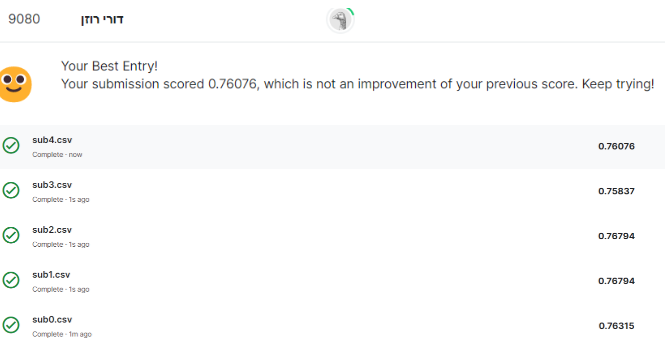

The following pictures are of some of my submissions: sub0 : This submission inclueds the following features: Pclass Sex Age SibSp Parch Fare (C S Q)Embarked Have_Cabin

sub1 : This submission included this features: Pclass Sex Age SibSp Family (C S Q)Embarked Have_Cabin

sub2 : This submission included this features: Pclass Sex Age Title SibSp Parch Fare (C S Q)Embarked Have_Cabin

sub3 : This submission included this features: Pclass Sex (Age)Encoded Title SibSp Parch Fare (C S Q)Embarked Have_Cabin

sub4 : This submission included this features: farecategory Survived Pclass Sex (Age)Encoded Family (C S Q)Embarked Have_Cabin


# Summary 

"In this homework i tried to solve the titanic problam. I droped features that i think is unnecessary for predicting the survival, such as: name, ticket and passengers ids. I analayzed the data and tried to find new features that will help me better predict the survival. I had found that diffrent marrige title names had diffrent rate of survival so i decidad to add this feature, also i had found that diffrent age groups had diffrent rate of survival so it was also a good indicatin. I made the ages to be labeled,also for outlier . i mada Sex cabin and Embarked to be on hot encoding. i didnt drop cabin becuse each detail i have is important. i coluld drop it but i choose to save it and to tell which has a cabin and who doesnt.

After analyzing the data and adding the new features i tried to find the bext slicing of the train data to train and validation and decided on a 80/20 split.

Then i set up an SGD Classifier and predicted the survival rate of the test data and submitted it for each model of chosen features i added .


**I am disappointed with the results, because it seems to me that I did a good job. It is not clear how the results come out so close or equal to each other even though they are completely different. I thought about the logic of this thing but I don't have an answer**

# references

1. Fourth Practice ML notebook
2. Fifth Practice ML notebook
3. Third Practice ML notebook
4. Titanic Data Science Solutions - https://www.kaggle.com/code/startupsci/titanic-data-science-solutions
5. https://www.geeksforgeeks.org/?newui

# **Exercise 3**

**Dor rozen**

**ID : 207043951**

**Site - https://www.kaggle.com/dorirosen**

# TL;DR

In this homework, I will try to improve my solution to the Kaggle contest "Titanic - Machine Learning from Disaster", as the contest name applies we need to categorize the titanic passengers as survivors and victims using Machine Learning.

In this notebook I will:
  1. i will research again the data and prepare a new module for training .
  2. perform feature selection.
  3. explore different hyperparameters..
  4. check which model is better KNN or SGDclasifier
  5. show KFold CV.
  6. show KPIs.

I chose to examine KNN because I believe that closely related predictions belong to the same classification.


# Titanic Report
i want to understand better the data


                                             |          | [  0%]   00:00 -> (? left)


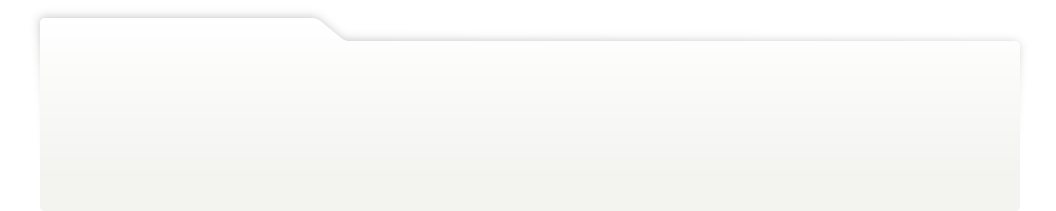
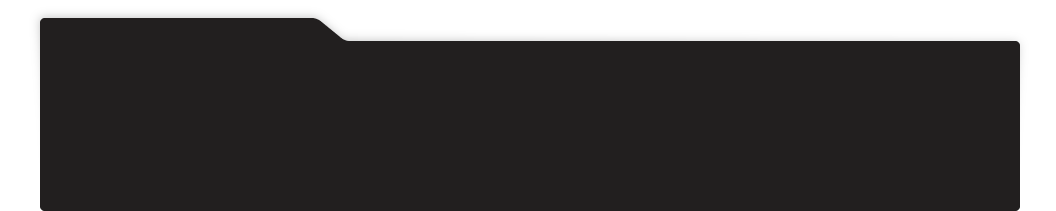
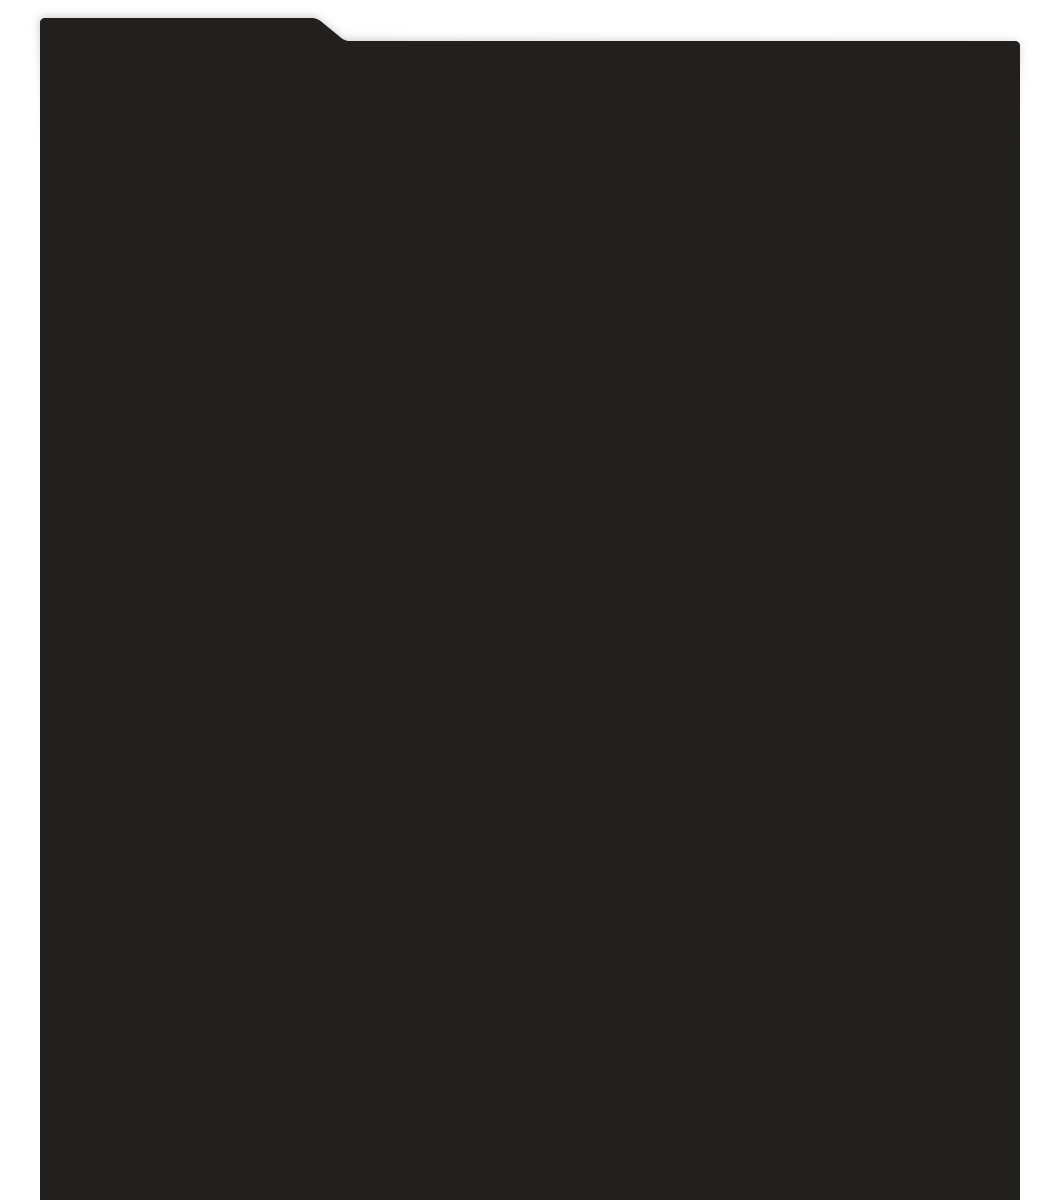
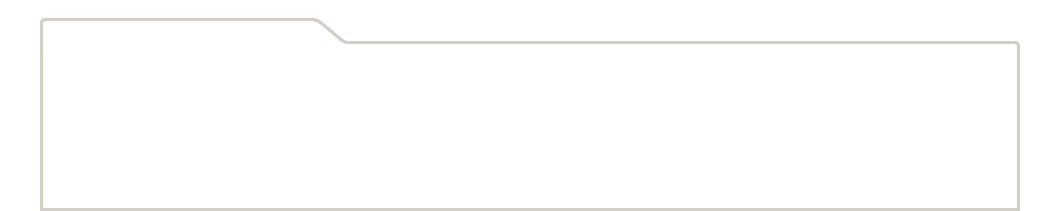
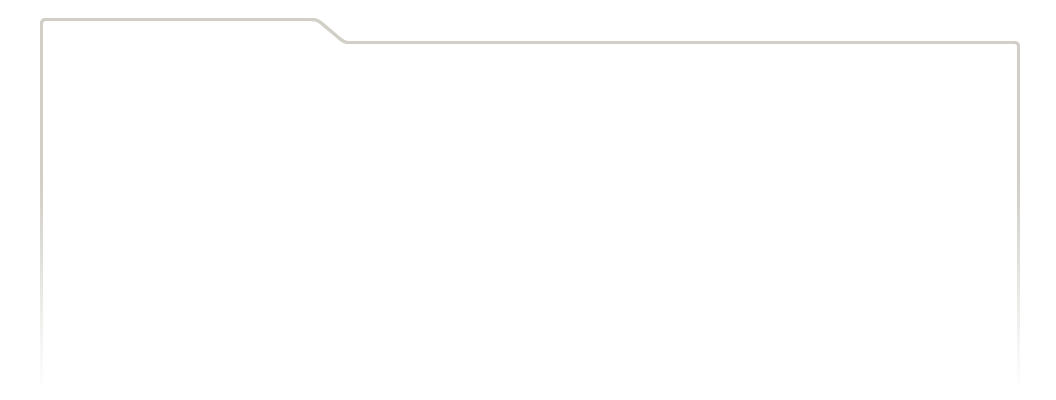
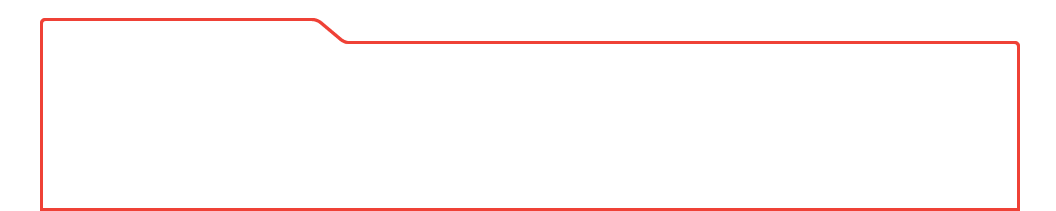
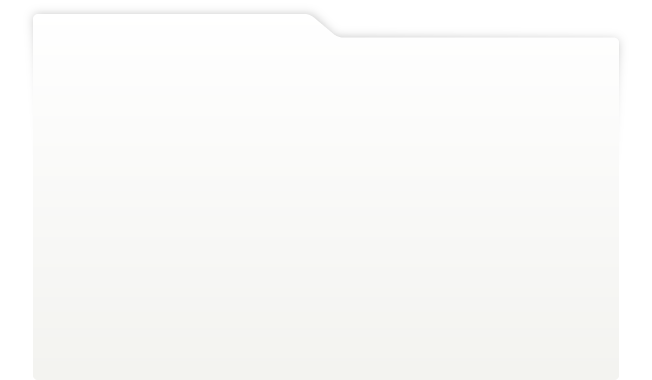
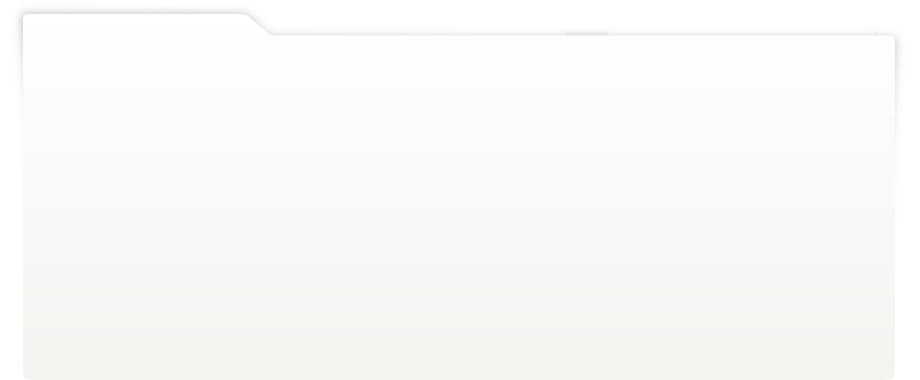
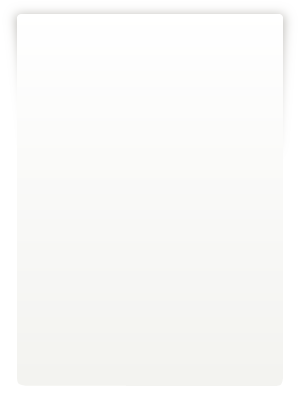
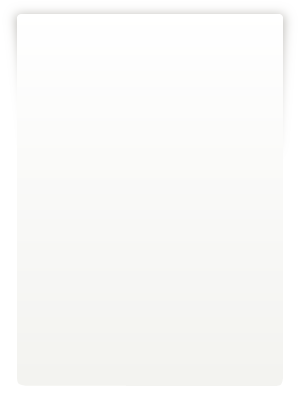
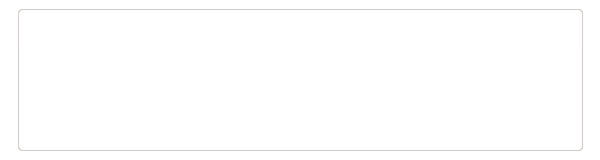
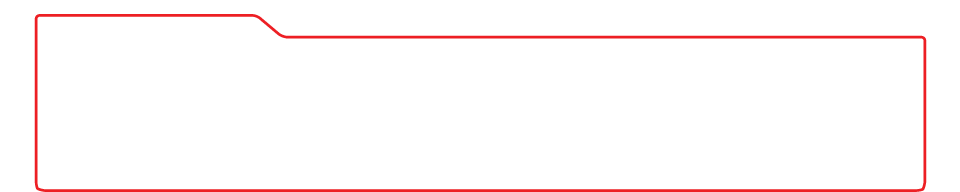
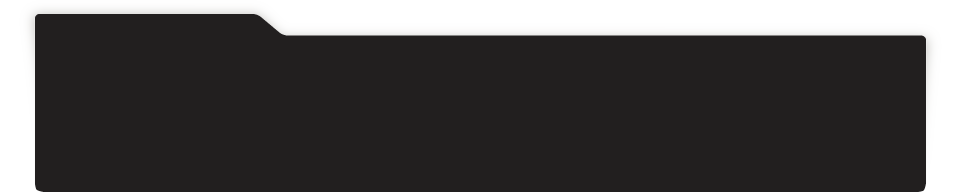
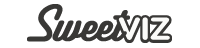
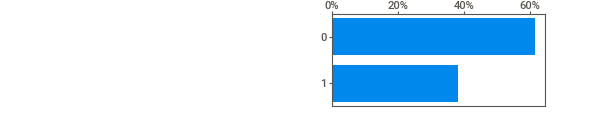
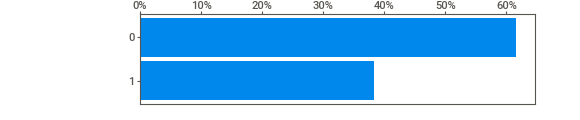
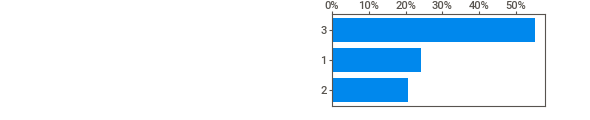
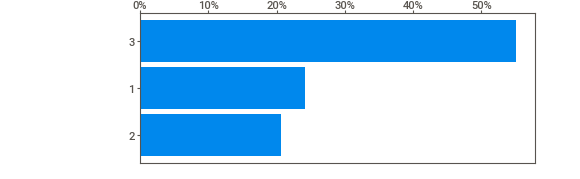
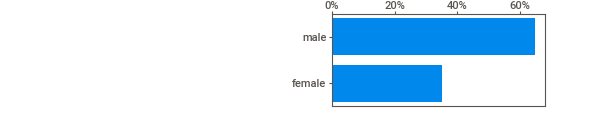
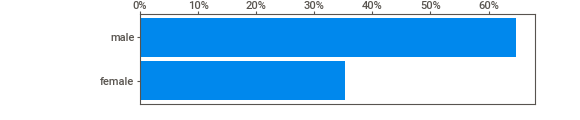
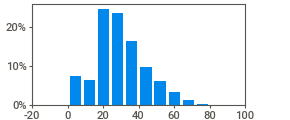
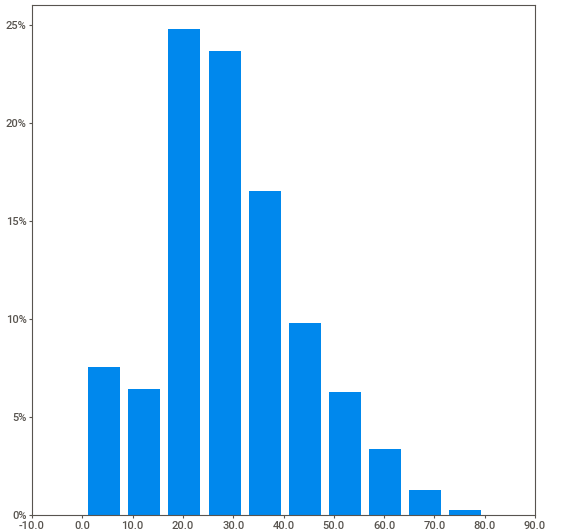
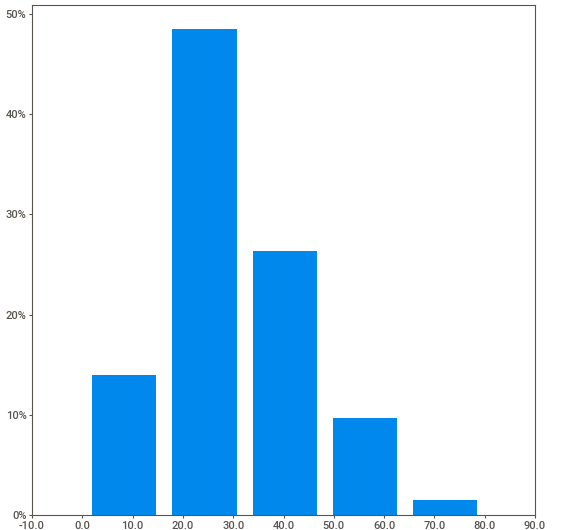
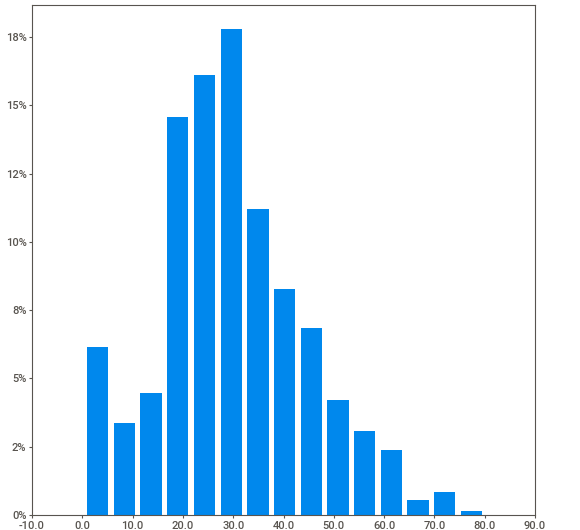
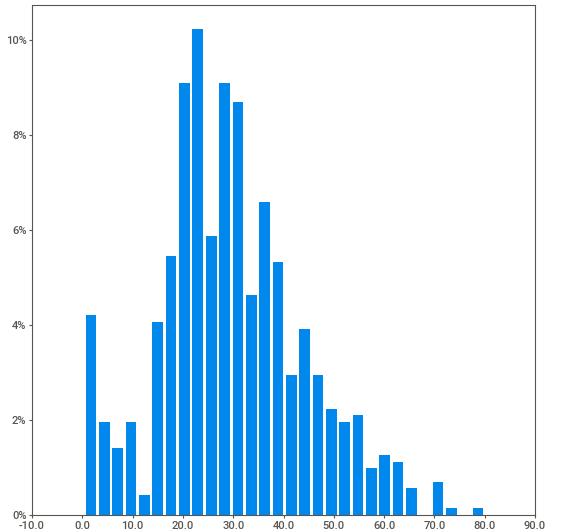
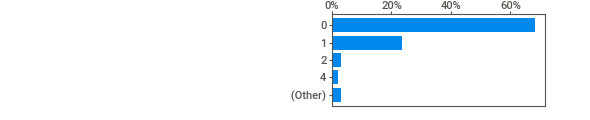
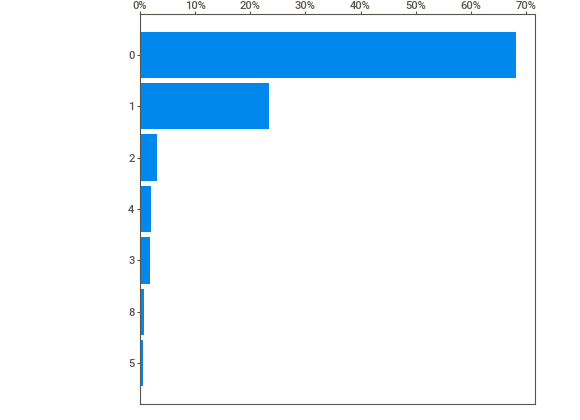
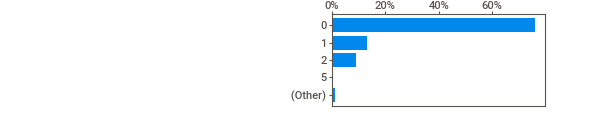
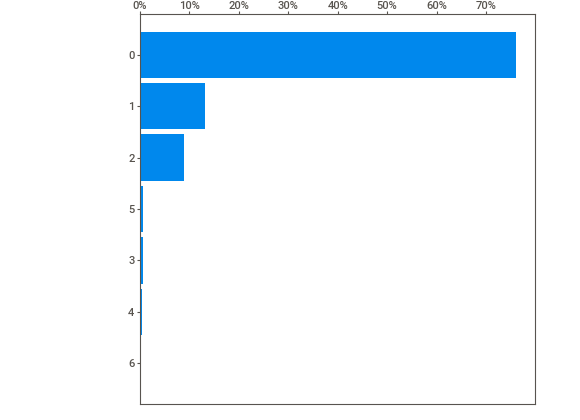
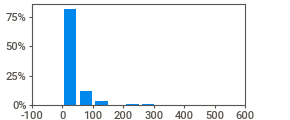
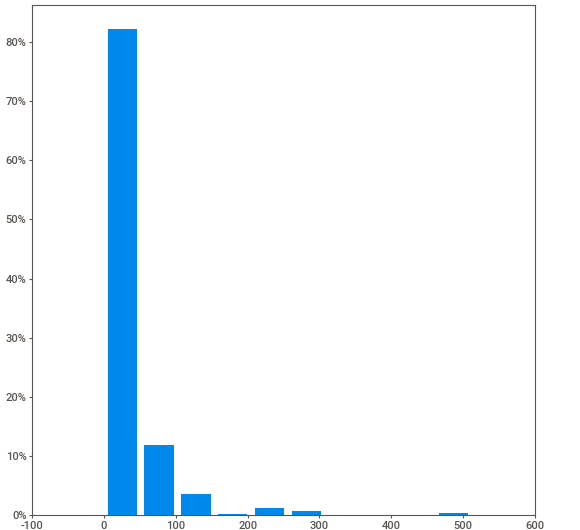
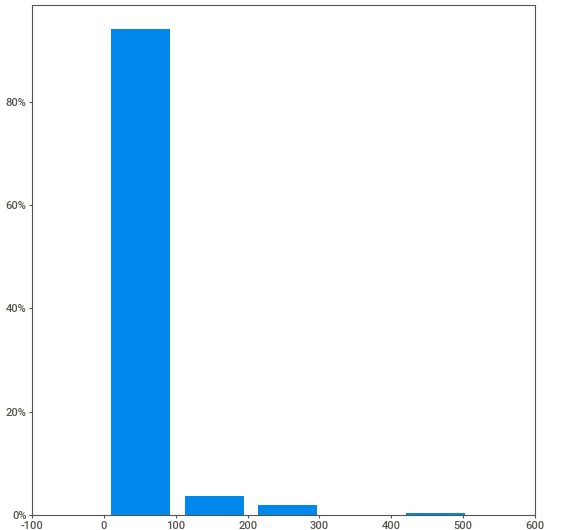
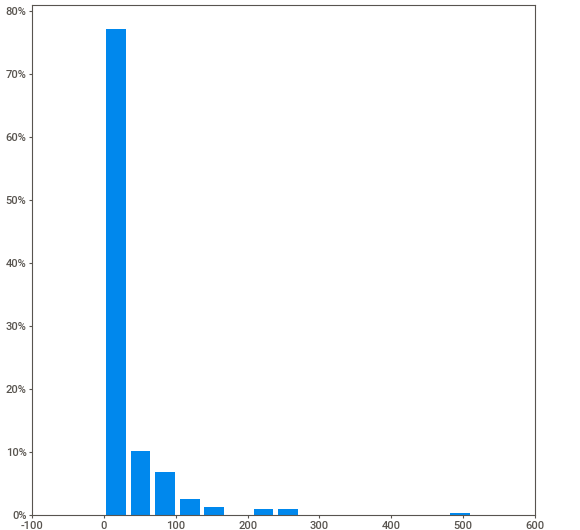
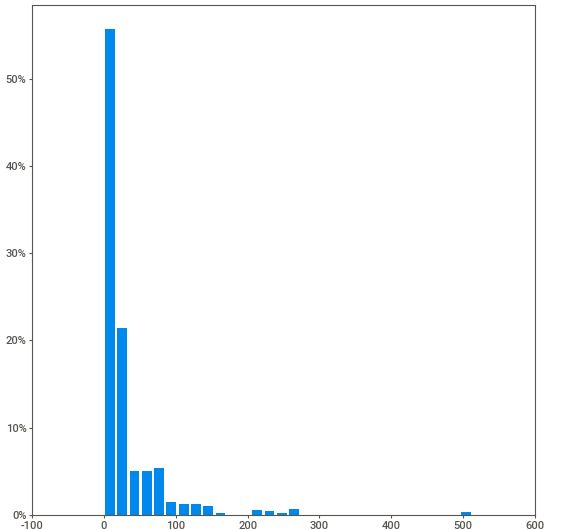
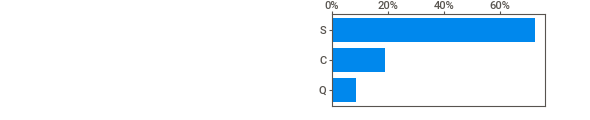
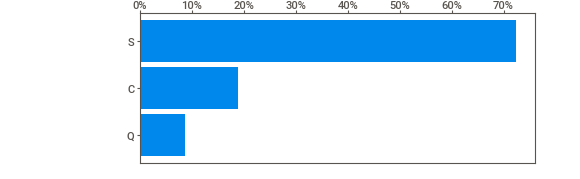
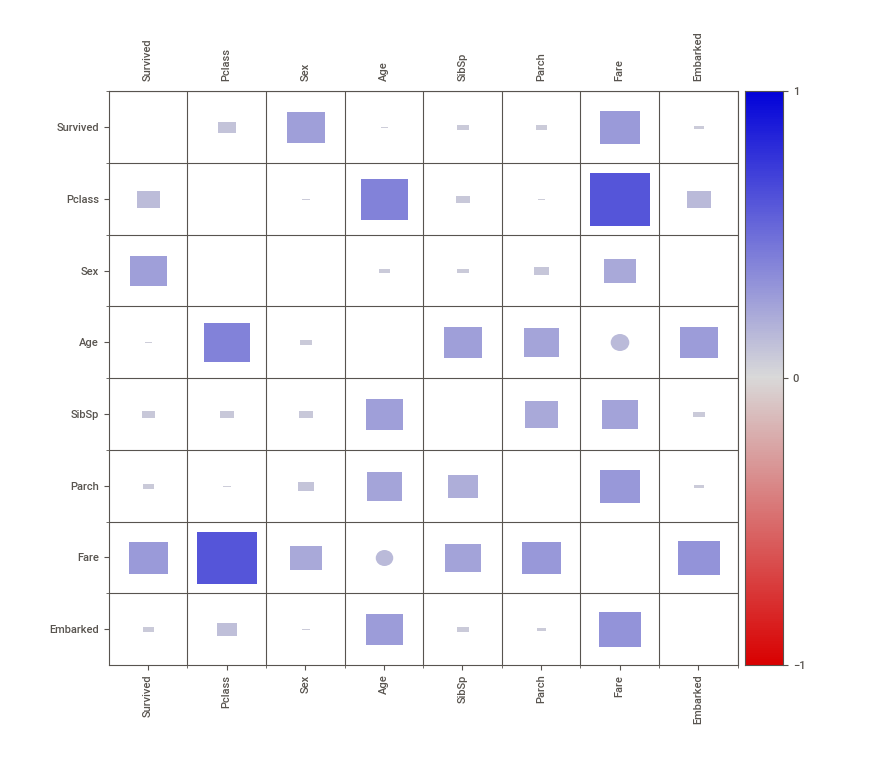
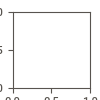

In [30]:
import sweetviz as sw
titanicReport = sw.analyze(df)
titanicReport.show_notebook(layout='vertical')

In [31]:
df = readData()

# Functions for finding what to drop
- Dealing with NULL values
- Distinct catagories fall into same catagories.
- features that are correlated to each other
- not Correlated With the target

In [32]:
#Drop features that are correlated to each other
def FeaturesCorrelatedToEachOther(data):
    covarianceMatrix = data.corr()
    listOfFeatures = [i for i in covarianceMatrix]
    setOfDroppedFeatures = set() 
    for i in range(len(listOfFeatures)) :
        for j in range(i+1,len(listOfFeatures)): #Avoid repetitions 
            feature1=listOfFeatures[i]
            feature2=listOfFeatures[j]
            if abs(covarianceMatrix[feature1][feature2]) > 0.8: #If the correlation between the features is > 0.8
                setOfDroppedFeatures.add(feature1) #Add one of them to the set
    return setOfDroppedFeatures

def nonCorrelatedWithOutput(data):
    nonCorrelatedWithOutput = [column for column in data if abs(data[column].corr(data["Survived"])) < 0.1]
    for i in nonCorrelatedWithOutput:
        print(f'{i} : {abs(data[i].corr(data["Survived"]))}')
    return nonCorrelatedWithOutput

def FeatureTitles(X):
    X['Title'] = X.Name.str.extract(' ([A-Za-z]+)\.', expand=False)#extract title name
    pd.crosstab(X['Title'], X['Sex'])# show count of title names by sex
    rare_titles = ['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona', 'Mlle', 'Ms', 'Mme']
    X['Title'] = X['Title'].replace(rare_titles, 'Rare') 
    title_mapping = {"Rare": 1, "Mr": 2, "Master": 3, "Mrs": 4, "Miss": 5}
    X['Title'] = X['Title'].map(title_mapping)
    return X
    
def fillCabin(data):
    data['Have_Cabin']= np.where(data['Cabin'].isnull(), 0, 1)
    return data

def addingFeatures(data):
    data.insert(len(data.columns), 'IsAlone', 0)
    data.loc[data['SibSp'] + data['Parch'] == 0, 'IsAlone'] = 1
    data["Family"] = data["Parch"] + data["SibSp"] 
    return data

def sexFiller(data):
    sex_one_hot = pd.get_dummies(data['Sex'])
    data = data.join(sex_one_hot)
    data = data.drop('Sex', axis=1)
    return data

def getObjects(data,whatToGet):
    return data.select_dtypes(whatToGet).columns

# Functions For Visualization Things

In [33]:
def show_accuracy_by_encoder(dfs, encoder_names):
    accuracy_df = pd.DataFrame(columns=['encoder_name', 'split', 'accuracy'])

    for i, df in enumerate(dfs):
        X = df.drop(['Survived'],axis=1)
        t = df['Survived']
        X_train, X_val, t_train, t_val = train_test_split(X, t, test_size=0.3, random_state=42)
        encoder_name = encoder_names[i]
        model = LinearRegression()
        model.fit(X_train, t_train)
        accuracy_df.loc[len(accuracy_df)] = [encoder_name, 'train', model.score(X_train, t_train)]
        accuracy_df.loc[len(accuracy_df)] = [encoder_name, 'val', model.score(X_val, t_val)]

    fig = px.bar(accuracy_df, x='encoder_name', y='accuracy', color='split', barmode='group')
    #img_bytes = fig.to_image(format="png", width=600, height=350, scale=2)
    display(fig)
    
def encode(df, columns_names, enc):
    df_cp = df.copy()
    feature_names = [str(name) for name in data_object]
    if enc == le:
        df_enc = df_cp.copy()
        for features in feature_names:
            df_enc[features] = le.fit_transform(df_cp[features].astype(str))
    else:
        df_cat = df_cp[columns_names]
        df_cat_enc = pd.DataFrame(enc.fit_transform(df_cat))
        df_enc = df_cp.drop(columns_names, axis=1).join(df_cat_enc)
    return df_enc

# check about empty details

In [34]:
count_empty_values_in_each_column(df)


empty values
------------

Age: 177
Cabin: 687
Embarked: 2


['Age', 'Cabin', 'Embarked']

# filling the data
- first of all i will take all the object types from my data.
- then i will encode the data in three ways and i will try to find from a plot which is the best encoder for my training.

In [35]:
def fillAllData(data):
    print(f'Before filling \n')
    count_empty_values_in_each_column(data)
    data = fillCabin(data)
    data = FeatureTitles(data)
    data = addingFeatures(data)
    data = sexFiller(data)
    Drop(data,['Cabin','Name','Ticket'])
    categorical_featuresTrain = getObjects(data,'object')
    Float_features = getObjects(data,'float64')
    int_features = getObjects(data,'int64')
    fill_na_mean(data, Float_features)
    fill_na_median(data,int_features)
    fill_na_mode(data, categorical_featuresTrain)
    print(f'After filling \n')
    count_empty_values_in_each_column(data)
    return data


# Make all data to be numric


In [36]:
df = fillAllData(df)

Before filling 

empty values
------------

Age: 177
Cabin: 687
Embarked: 2
After filling 

empty values
------------



In [37]:
df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked,Have_Cabin,Title,IsAlone,Family,female,male
0,0,3,22.0,1,0,7.2500,S,0,2,0,1,0,1
1,1,1,38.0,1,0,71.2833,C,1,4,0,1,1,0
2,1,3,26.0,0,0,7.9250,S,0,5,1,0,1,0
3,1,1,35.0,1,0,53.1000,S,1,4,0,1,1,0
4,0,3,35.0,0,0,8.0500,S,0,2,1,0,0,1


checking which encoder is the best for my data with the encoders

In [38]:
data_object = getObjects(df,'object')
# only embarked
de = OneHotEncoder(drop="first", sparse=False).fit(df[data_object])
oe = OrdinalEncoder().fit(df[data_object])
le = LabelEncoder()
encoder_names = ['Dummy Encoder', 'Ordinal Encoder', "Label Encoder"]

df_de = encode(df, data_object, de)
df_oe = encode(df, data_object, oe)
df_le = encode(df, data_object, le)
dfs = [df_de, df_oe, df_le]
show_accuracy_by_encoder(dfs, encoder_names)

its not saying much , but there is a little diffrent that say that dummy encoder is the best for the embarked feature.
any way , i will choose the one hot encoder .

In [39]:
x = data_object.tolist()
df = pd.get_dummies(df, columns=x, prefix=x)

In [40]:
df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Have_Cabin,Title,IsAlone,Family,female,male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,0,2,0,1,0,1,0,0,1
1,1,1,38.0,1,0,71.2833,1,4,0,1,1,0,1,0,0
2,1,3,26.0,0,0,7.9250,0,5,1,0,1,0,0,0,1
3,1,1,35.0,1,0,53.1000,1,4,0,1,1,0,0,0,1
4,0,3,35.0,0,0,8.0500,0,2,1,0,0,1,0,0,1


In [41]:
df = readData()
df = fillAllData(df)
x = data_object.tolist()
df = pd.get_dummies(df, columns=x, prefix=x)

Before filling 

empty values
------------

Age: 177
Cabin: 687
Embarked: 2
After filling 

empty values
------------



# Dividing the data


In [42]:
t = df['Survived'].copy()
X = df.drop(['Survived'], axis=1)

In [43]:
print("train data :\n\n")
display(X)
count_empty_values_in_each_column(X)
print("val data:\n\n")
display(t)

train data :




,Pclass,Age,SibSp,Parch,Fare,Have_Cabin,Title,IsAlone,Family,female,male,Embarked_C,Embarked_Q,Embarked_S
0,3,22.000000,1,0,7.2500,0,2,0,1,0,1,0,0,1
1,1,38.000000,1,0,71.2833,1,4,0,1,1,0,1,0,0
2,3,26.000000,0,0,7.9250,0,5,1,0,1,0,0,0,1
3,1,35.000000,1,0,53.1000,1,4,0,1,1,0,0,0,1
4,3,35.000000,0,0,8.0500,0,2,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,2,27.000000,0,0,13.0000,0,1,1,0,0,1,0,0,1
887,1,19.000000,0,0,30.0000,1,5,1,0,1,0,0,0,1
888,3,29.699118,1,2,23.4500,0,5,0,3,1,0,0,0,1
889,1,26.000000,0,0,30.0000,1,2,1,0,0,1,1,0,0


empty values
------------

val data:




0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

## Feature Selection
I will performe feature selection on the data

In [44]:
featureSelector = RFECV(SGDClassifier(loss = "log", random_state = 1), cv = RepeatedKFold(n_splits = 2, n_repeats = 10, random_state = 1)).fit(X, t)
xSelected = X.loc[:, featureSelector.support_]
xSelected.info()
Drop(df,['Embarked_S','Age','Fare','female','Parch']) # for heatmap that has the survived feature

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Pclass      891 non-null    int64
 1   SibSp       891 non-null    int64
 2   Have_Cabin  891 non-null    int64
 3   Title       891 non-null    int64
 4   IsAlone     891 non-null    int64
 5   Family      891 non-null    int64
 6   male        891 non-null    uint8
 7   Embarked_C  891 non-null    uint8
 8   Embarked_Q  891 non-null    uint8
dtypes: int64(6), uint8(3)
memory usage: 44.5 KB


As we can see the best features that was extracted by backward selection are

1. Pclass
2. SibSp
3. Have_Cabin
4. Title
5. IsAlone
6. Family
7. male
8. Embarked_C
9. Embarked_Q

note : 
i will use the model that found this features an an ensumble later on.

**now i will look at the Correlations**


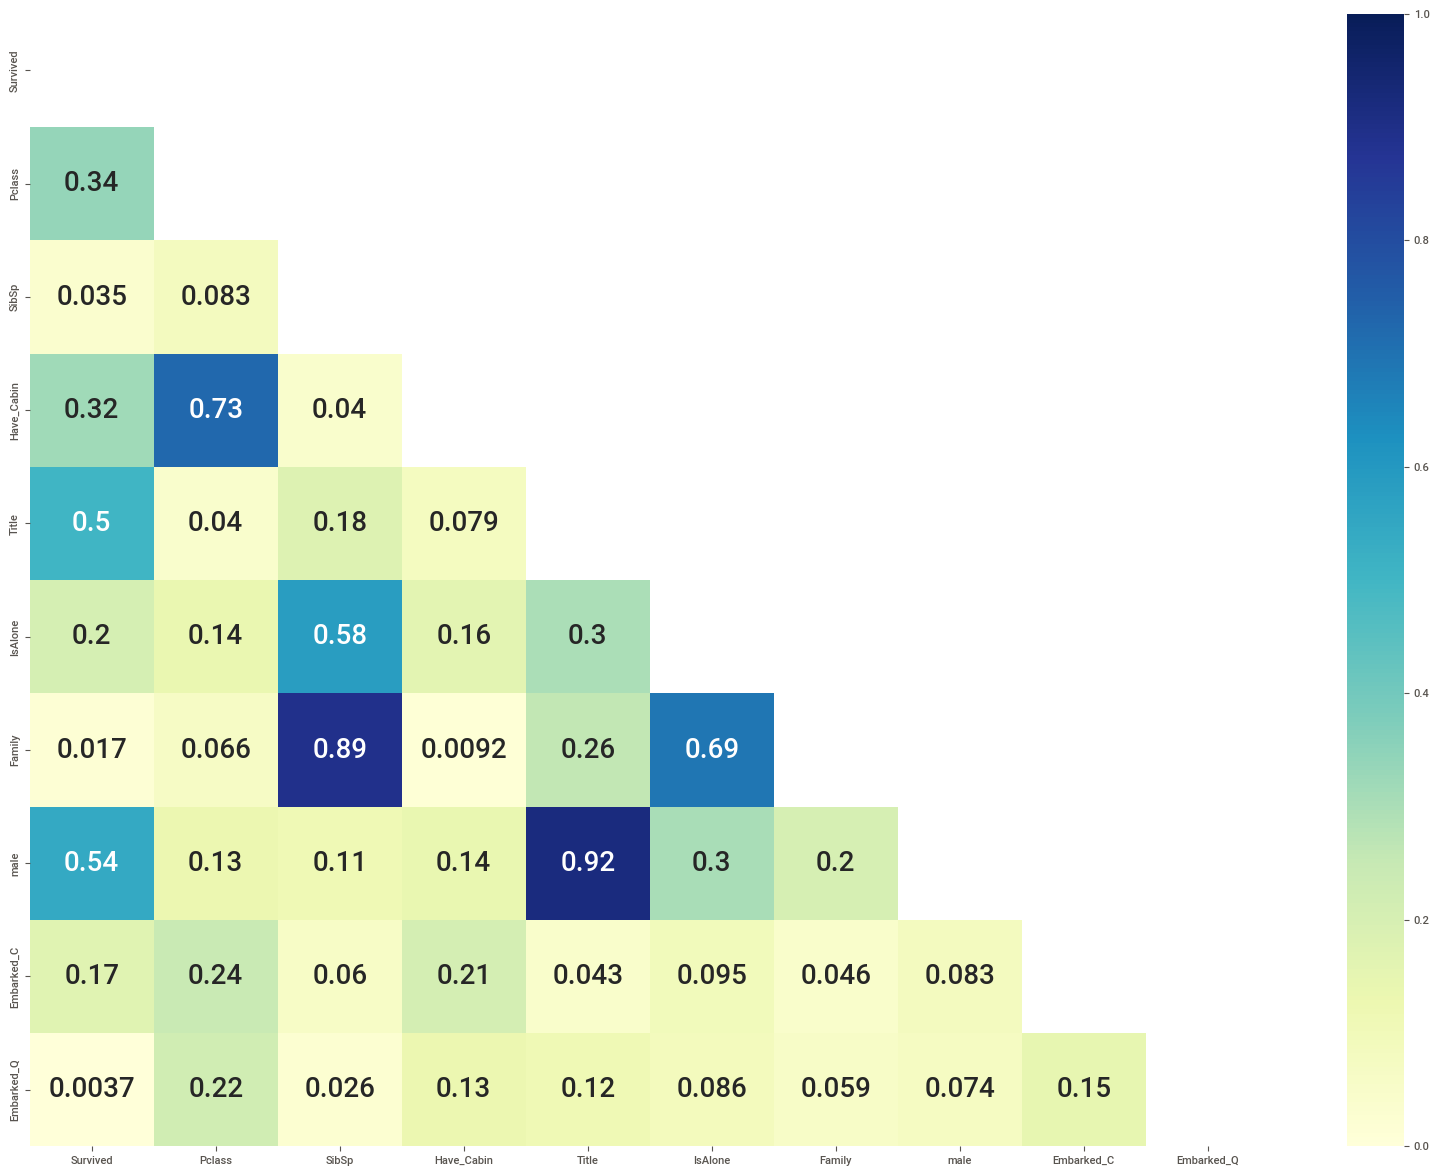

In [45]:
X = xSelected
show_heatmap(df)

# conclusion from the correlations

Correlation is a statistical measure that describes the association between random variables. It is one of the most widely used statistical concepts. In our case, we can view correlation from two different points of view:

 1. Correlation of features with each other

 2. Correlation of features with output

- In the first case, we will tend to drop features that are correlated to each other, since a high correlation between features indicates that the features bring up almost the same information, so it will be a waste of time and a waste of resources to consider such features.

**conclusion : i will drop features that are correlated to each other more then 80%**

**we can see clearly that male are very correlated to Title.**

**and for sure i need the decide which feature to drop . male or Title.**

**so i will look at the correlation between them to the survived feature and see who is the best , and drop the other one .**

**here we can see that male : 0.54 and Title:0.5 so i will drop the title feature.**

- In the second case, we will tend to drop features that are not correlated to the output, since a low correlation between a feature and the output indicates that such feature is not really associatied with output and doesn't contribute much to the final result.

**conclusion : i will drop correlation threshold - 0.045 with 'Survived'**

In [46]:
toDrop = nonCorrelatedWithOutput(df)
FeaturesCorrelatedToEachOther(df)
toDrop += ['Title']
Drop(X,toDrop)
X.head()

SibSp : 0.035322498885735645
Family : 0.016638989282745254
Embarked_Q : 0.0036503826839719387


,Pclass,Have_Cabin,IsAlone,male,Embarked_C
0,3,0,0,1,0
1,1,1,0,0,1
2,3,0,1,0,0
3,1,1,0,0,0
4,3,0,1,1,0


normalizes the data

In [47]:
scaler = StandardScaler()
ct = make_column_transformer((scaler,['Pclass']),remainder = 'passthrough')
transformed_features = X.columns
temp = ct.fit_transform(X)
X = pd.DataFrame(temp,columns=transformed_features)

now i wanted to check about outliers but .. there is nan of them 

# So Now
i will check KNN module and will also cheack what is the best number of neigbors for KNN.

In [48]:
hyper_parameters = {'n_neighbors': list(range(1, 20))}

gs_neigh_model = GridSearchCV(KNeighborsClassifier(n_neighbors=5), hyper_parameters).fit(X, t)
print('Accuracy score for classification Neighbors:')
print('gs_neigh_model', gs_neigh_model.best_score_)
print('best params', gs_neigh_model.best_params_)

bestKNNClassifier = KNeighborsClassifier(n_neighbors = gs_neigh_model.best_params_['n_neighbors']).fit(X, t)

Accuracy score for classification Neighbors:
gs_neigh_model 0.7980038917833155
best params {'n_neighbors': 11}


As we can see the best number of neighbors is 11 for the KNN model.

Now lets check what is the best hyper parameters for the SGD classifier.

In [49]:
hyper_parameters = {"penalty": ["l2", "l1", "elasticnet"], "alpha": [0.0001, 0.001, 0.01, 0.1], "eta0": [0.0001, 0.001, 0.01, 0.1]}

gs_model = GridSearchCV(SGDClassifier(loss = "log", random_state=1), hyper_parameters).fit(X, t)
print('Accuracy score for classification:')
print('gs_model', gs_model.best_score_)
print('best params', gs_model.best_params_)

bestSGDClassifier = SGDClassifier(loss = "log", penalty = gs_model.best_params_['penalty'], alpha = gs_model.best_params_['alpha'], learning_rate = "constant", eta0 = gs_model.best_params_['eta0'], random_state = 42).fit(X, t)

Accuracy score for classification:
gs_model 0.7867365513778168
best params {'alpha': 0.01, 'eta0': 0.0001, 'penalty': 'l1'}


As we can see the best hyper parmeters for the SGDclassifier are:

alpha: 0.01 

eta0 : 0.0001

penalty : l1

We can also see that the KNN got an higher accurcy then the SGDclassifier then we will use KNN


## Ensembles

Let's experiment with ensembles, meaning we'll create a collection of models to make more accurate predictions and lower the variance. Since we use classification, we can take the mean of all the probabilities of the model or choose the class that most of the models chose for some sample, just like majority vote.

Let's find the best Ensembles hyper parameters from the next options:

n_estimators: 10, 11 ... 20
bootstrap: True / False

In [50]:
def getOptimalAmountOfEstinators(x, t, baseEstimator):
    hyperParams = {"n_estimators": list(range(10, 21)), "bootstrap": [True, False]}
    gridSearch = GridSearchCV(BaggingClassifier(base_estimator = baseEstimator, random_state = 42), hyperParams, scoring = "neg_log_loss").fit(x, t)
    return gridSearch.best_params_["n_estimators"], gridSearch.best_params_["bootstrap"]


bestAmountOfEstimators, usingBootstrap = getOptimalAmountOfEstinators(X, t, bestSGDClassifier)
print("Best Ensembles hyper-parameters for SGD:")
print(f"\t# Estimators: {bestAmountOfEstimators}\n\tBootstrap: {usingBootstrap}")

ensembles_SGD_Classifier = BaggingClassifier(base_estimator = bestSGDClassifier, n_estimators = bestAmountOfEstimators, bootstrap = usingBootstrap, random_state = 42).fit(X, t)

bestAmountOfEstimators, usingBootstrap = getOptimalAmountOfEstinators(X, t, bestKNNClassifier)
print("Best Ensembles hyper-parameters for Knn:")
print(f"\t# Estimators: {bestAmountOfEstimators}\n\tBootstrap: {usingBootstrap}")

ensembles_KNN_Classifier = BaggingClassifier(base_estimator = bestKNNClassifier, n_estimators = bestAmountOfEstimators, bootstrap = usingBootstrap, random_state = 42).fit(X, t)

Best Ensembles hyper-parameters for SGD:
	# Estimators: 20
	Bootstrap: True
Best Ensembles hyper-parameters for Knn:
	# Estimators: 12
	Bootstrap: True


# KFold CV

In [57]:
# Required methods:
def getGeneratorLength(generator, useProgressBar = True):
    i = 0
    
    if useProgressBar:
        pbar = tqdm(desc = "Calculating Length", ncols = 1000, bar_format = "{desc}{bar:10}{r_bar}")
    for a in generator:
        i += 1
        if useProgressBar:
            pbar.update()

    if useProgressBar:
        pbar.close()

    return i

def showCVResults(x, t, model, k = None, p = None, showGraphs = False, showProgressBar = True):
    resultsDF = pd.DataFrame(columns = ["Fold ID", "Split", "Score", "Loss"])
    cvMethod = ""

    if k is not None:
        cvMethod = "K-Fold"
        cv = KFold(n_splits = k, shuffle = True, random_state = 42)
    elif p is not None:
        cvMethod = f"Leave-{p}-Out"
        cv = LeavePOut(p)
    else:
        raise ValueError("Choose k (for K-Fold) or p (for Leave-P-Out)")

    if showProgressBar:
        pbar = tqdm(desc = "Computing Models", total = getGeneratorLength(cv.split(x)))

    for i, (trainIDs, validationIDs) in enumerate(cv.split(x)):
        xTrain = x.loc[trainIDs]
        tTrain = t.loc[trainIDs]
        xValidation = x.loc[validationIDs]
        tValidation = t.loc[validationIDs]

        model.fit(xTrain, tTrain)

        yTrain = model.predict_proba(xTrain)
        yValidation = model.predict_proba(xValidation)
        resultsDF.loc[len(resultsDF)] = [i, "train", model.score(xTrain, tTrain),
                                         log_loss(tTrain, yTrain)]
        resultsDF.loc[len(resultsDF)] = [i, "validation", model.score(xValidation, tValidation),
                                         log_loss(tValidation, yValidation)]

        if showProgressBar:
            pbar.update()

    if showProgressBar:
        pbar.close()

    validationResultsDF = resultsDF[resultsDF["Split"] == "validation"]
    trainResultsDF = resultsDF[resultsDF["Split"] == "train"]

    validationScoreMean = validationResultsDF["Score"].mean()
    validationLossMean = validationResultsDF["Loss"].mean()
    trainScoreMean = trainResultsDF["Score"].mean()
    trainLossMean = trainResultsDF["Loss"].mean()

    if showGraphs:
        scoreTitle = f"{k if k is not None else p} {cvMethod} (Score):<br />Mean Validation Score: {validationScoreMean:.2f}<br />Mean Train Score: {trainScoreMean:.2f}"
        lossTitle = f"{k if k is not None else p} {cvMethod} (Loss):<br />Mean Validation Loss: {validationLossMean:.2f}<br />Mean Train Loss: {trainLossMean:.2f}"

        scoreFig = px.line(resultsDF, x = "Fold ID", y = "Score", color = "Split", title = scoreTitle)
        scoreFig.show()

        lossFig = px.line(resultsDF, x = "Fold ID", y = "Loss", color = "Split", title = lossTitle)
        lossFig.show()

    return validationScoreMean, validationLossMean, trainScoreMean, trainLossMean

validationScore, validationLoss, trainScore, trainLoss = showCVResults(X, t, ensembles_SGD_Classifier, k = 5, showGraphs = True)
validationScore, validationLoss, trainScore, trainLoss = showCVResults(X, t, ensembles_KNN_Classifier, k = 10, showGraphs = True)
validationScore, validationLoss, trainScore, trainLoss = showCVResults(X, t, ensembles_SGD_Classifier, k = 5, showGraphs = True)
validationScore, validationLoss, trainScore, trainLoss = showCVResults(X, t, ensembles_KNN_Classifier, k = 10, showGraphs = True)

Calculating Length          | 0/? [00:00<?, ?it/s]

Computing Models:   0%|          | 0/5 [00:00<?, ?it/s]

Calculating Length          | 0/? [00:00<?, ?it/s]

Computing Models:   0%|          | 0/10 [00:00<?, ?it/s]

Calculating Length          | 0/? [00:00<?, ?it/s]

Computing Models:   0%|          | 0/5 [00:00<?, ?it/s]

Calculating Length          | 0/? [00:00<?, ?it/s]

Computing Models:   0%|          | 0/10 [00:00<?, ?it/s]

In [52]:
# Required Methods
def showConfusionMatrix(confusionMatrixData):
    confusionMatrix = pd.DataFrame(confusionMatrixData, index = ["Died", "Survived"],columns = ["Predicted to Die", "Predicted to Survive"])
    fig = sns.heatmap(confusionMatrix, annot = True, cmap = plt.cm.BuGn, fmt = "g")
    fig.set_title("Cofusion Matrix")
    plt.show()

def showROCGraph(labels, probabilities):
    aucScore = roc_auc_score(labels, probabilities[:, 1])
    fpr, tpr, thresholds = roc_curve(labels, probabilities[:, 1])
    rocDF = pd.DataFrame({"False Positive Rate": fpr, "True Positive Rate": tpr, "Thresholds": thresholds})

    fig = px.line(rocDF, title = f"AUC: {aucScore:.2f}", x = "False Positive Rate", y = "True Positive Rate")
    fig.show()

def calculateKPIs(cm):
    tn, fp, fn, tp = cm.ravel()
    kpisDict = {}

    kpisDict["Accuracy"] = (tp + tn) / (tp + tn + fp + fn)
    kpisDict["Precision"] = precision = tp / (tp + fp)
    kpisDict["Recall"] = recall = tp / (tp + fn)
    kpisDict["Specificity"] = specificity = tn / (tn + fp)
    kpisDict["FPR"] = fp / (fp+tn)
    kpisDict["F1"] = (2 * precision * recall) / (precision + recall)
    kpisDict["Balanced Accuracy"] = (recall + specificity) / 2

    return kpisDict

def cross_val_predict_proba(estimator, x, t, k = 5):
    yProbabilities = []
    for (trainOffsets, validationOffsets) in KFold(n_splits = k).split(x):
        xValidation = x.loc[validationOffsets]
        estimator.fit(x.loc[trainOffsets], t[trainOffsets])
        yProbabilities += list(estimator.predict_proba(xValidation))
    return np.array(yProbabilities)

KPIs:
	-Accuracy (The proportion of correct predictions (Survived + Died) among all passengers): 0.795
	-Precision (The fraction of retrieved predictions that are relevant to a given query): 0.796
	-Recall (The fraction of relevant predictions that are successfully retrieved): 0.626
	-Specificity (The proportion of the survivors who were predicted to die): 0.900
	-FPR (The probability of falsely rejecting the null hypothesis (in our case, being labeled a survivor) for a particular passenger): 0.100
	-F1 (The harmonic mean of Precision and Sensitivity): 0.700
	-Balanced Accuracy (Evaluation of how good a binary classifier is): 0.763


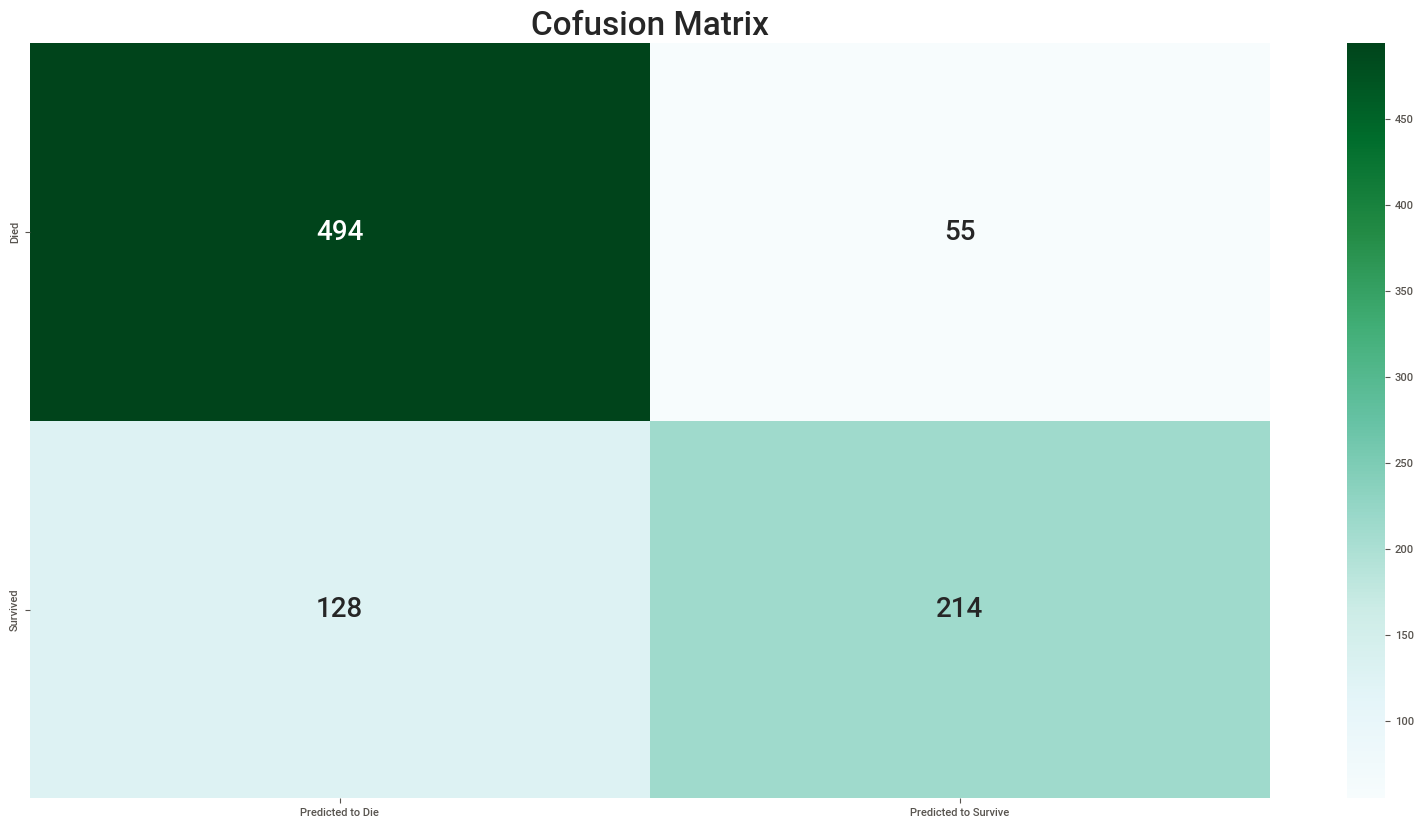

In [54]:
yPred = cross_val_predict(ensembles_KNN_Classifier, X, t)
yProb = cross_val_predict_proba(ensembles_KNN_Classifier, X, t, k = 5)
confusionMatrix = confusion_matrix(t, yPred)

# Displaying KPIs
kpiMeanings = {"Accuracy" : "The proportion of correct predictions (Survived + Died) among all passengers",
               "Precision" : "The fraction of retrieved predictions that are relevant to a given query",
               "Recall" : "The fraction of relevant predictions that are successfully retrieved",
               "Specificity" : "The proportion of the survivors who were predicted to die",
               "FPR" : "The probability of falsely rejecting the null hypothesis (in our case, being labeled a survivor) for a particular passenger",
               "F1" : "The harmonic mean of Precision and Sensitivity",
               "Balanced Accuracy" : "Evaluation of how good a binary classifier is"}

print("KPIs:")
for k, v in calculateKPIs(confusionMatrix).items():
    print("\t-{0} ({1}): {2:.3f}".format(k, kpiMeanings[k], v))

# Displaying confusion matrix and ROC graph
showConfusionMatrix(confusionMatrix)
showROCGraph(t, yProb)

# **Get ready for submission , Reading and repairing test data**
**Now i will make functions that will :**

**1. read the Test Data**

**2.filling and making all data to be numeric**

**3.create a submission**

In [55]:
def getfixedTestData(currectData):
    toReturn = readData(1)
    toReturn = fillAllData(toReturn)
    toDrop = currectData.columns.tolist()
    data_object = getObjects(toReturn,'object')
    x = data_object.tolist()
    toReturn = pd.get_dummies(toReturn, columns=x, prefix=x)
    toReturn = pd.DataFrame(toReturn, columns=toDrop)
    scaler = StandardScaler()
    ct = make_column_transformer((scaler,['Pclass']),remainder = 'passthrough')
    transformed_features = toReturn.columns
    temp = ct.fit_transform(toReturn)
    toReturn = pd.DataFrame(temp,columns=transformed_features)
    return toReturn

# Creating a submission file for the competition
def createCSVfile(model,test,theName):
    yTest = model.predict(test)
    ID = ForID()
    passangers_ids = ID['PassengerId'].copy()
    submission = pd.DataFrame()
    submission['PassengerId'] = passangers_ids
    submission['Survived'] = yTest
    strx = "submission"+theName+".csv"
    submission.to_csv(strx,index=False)
    print(f'{strx} created !')

# Submission

In [56]:
tf = getfixedTestData(X)
createCSVfile(ensembles_KNN_Classifier,tf,"_Num1_KNN")
createCSVfile(ensembles_SGD_Classifier,tf,"_Num2_SGD")

Before filling 

empty values
------------

Age: 86
Fare: 1
Cabin: 327
After filling 

empty values
------------

submission_Num1_KNN.csv created !
submission_Num2_SGD.csv created !


# First submission (Best) - submission_Num1_KNN

With the selected features and with ensemble and KNN.

Estimators: 20
Bootstrap: True
neighbors:  11 
# Second submission - submission_Num2_SGD

With the selected features and with ensemble and SGD.

Estimators: 12
Bootstrap: True
alpha: 0.01
eta0 : 0.0001
penalty : l1

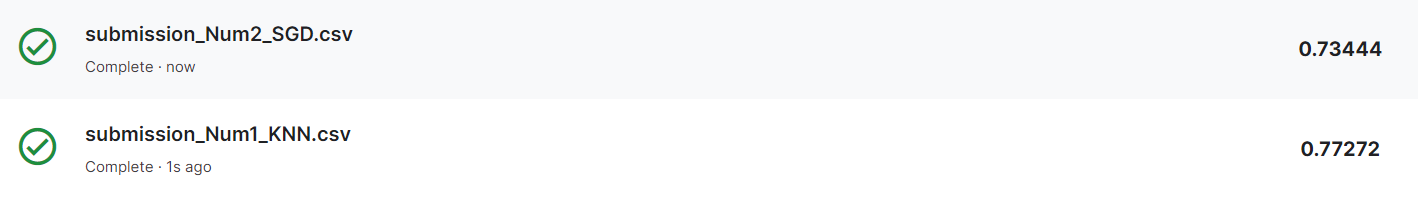


# **Summary**

In this exercise, I tried to improve my score on my last submission for the titanic contest.

I found that KNN with nearest neighbors set on 11 and an ensemble of 20 models gave me the best result.

I also used gridSearch to find the best penalty,eta0,alpha , and used also for KNN neighbors and bootstrap [True,False].

used ensembles BaggingClassifier on KNN and SGD classifiers.

I also used backward selection to extract the best featuers , and took out correlted features by my self .

in the end, I didnt success to improve my score from task 1 with the new technics I learned.

I tried a couple of different models but this one worked the best for me.

# References

Seventh Practice ML

Sixth Practic ML

Fifth Practice ML

In [ ]:
# for converting to HTML

"""
%%shell
jupyter nbconvert --to html /content/Titanic_2.ipynb
"""